In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True)

INFO:profiler.utility:[0.0064580440521240234] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', '?', 'nan', 'NaN', 'unknown', 'none', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred oper

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.10730600357055664] Load Embedding start

INFO:profiler.utility:[0.14310216903686523] Load Embedding execution time: 0.035796165466308594



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.14849400520324707] Create Training Data start

INFO:profiler.transformer:needs multiplier = 214 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 214, and the bound is 0.00006293
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 78.83it/s]
INFO:profiler.transformer:Number of training samples: 227772
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0318
INFO:profiler.utility:[7.774654150009155] Create Training Data execution time: 7.626160144805908



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, take_neg=True)

INFO:profiler.utility:[7.782302141189575] Learn Structure start

INFO:profiler.learner:use threshold 0.0374
INFO:profiler.utility:[7.824143171310425] Learn Structure execution time: 0.04184103012084961



* score: 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="training_data_fd_vio_ratio")

INFO:profiler.utility:[7.832834005355835] Get Dependencies start



HospitalName -> ProviderNumber (0.05568761344973636)
HospitalName,ProviderNumber -> Address1 (0.058239318977550976)
HospitalName,ProviderNumber,Address1 -> City (0.06687077805316616)
HospitalName,ProviderNumber,Address1,City -> ZipCode (0.05925472631633769)
HospitalName,ProviderNumber,Address1,City,ZipCode -> CountyName (0.07642589235049063)
HospitalName,ProviderNumber,Address1,City,ZipCode,CountyName -> PhoneNumber (0.062459726364058686)
HospitalName,ProviderNumber,Address1,City,CountyName,PhoneNumber -> HospitalOwner (0.045632841273168245)


INFO:profiler.utility:[8.119072914123535] Get Dependencies execution time: 0.2862389087677002



HospitalName,CountyName -> EmergencyService (0.04989128655927805)
Condition -> MeasureCode (0.6655881873948212)
Condition,MeasureCode -> Stateavg (0.06804973864484919)


## 5. Visualization

In [9]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

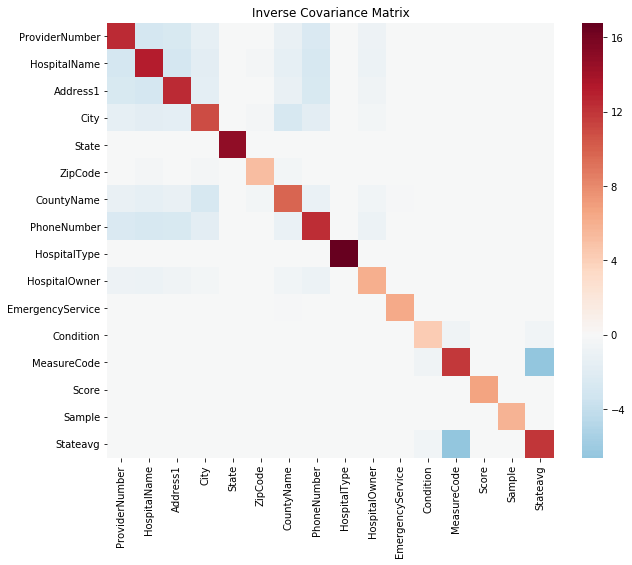

In [10]:
pf.session.visualize_inverse_covariance()

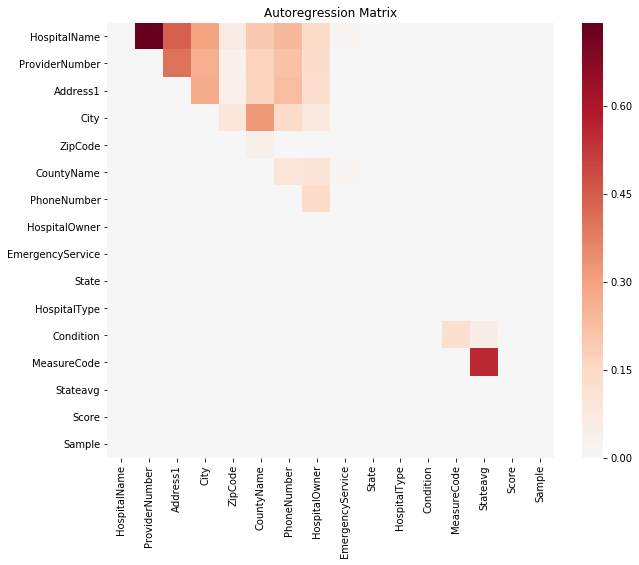

In [11]:
pf.session.visualize_autoregression()

In [12]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.006458,start: Load Data,0.000000
1,0.060727,end: Load Data,0.054269
2,0.107306,start: Load Embedding,0.000000
3,0.143102,end: Load Embedding,0.035796
4,0.148494,start: Create Training Data,0.000000
5,7.774654,end: Create Training Data,7.626160
6,7.782302,start: Learn Structure,0.000000
7,7.824143,end: Learn Structure,0.041841
8,7.832834,start: Get Dependencies,0.000000
9,8.119073,end: Get Dependencies,0.286239
